In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import textwrap
import statsmodels.formula.api as smf
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import pearsonr
from sklearn import mixture
from sklearn.preprocessing import minmax_scale
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import zscore
mpl.style.use('toby')

## Get data

In [60]:
group_df = pd.read_csv('../data/all_data_long.csv')
group_df_wide = pd.read_csv('../data/all_data_wide.csv')

## Use Bayesian Gaussian Mixture Model to identify subgroups

### Select question data and scale

In [62]:
random_state = 2
group_df_wide = group_df_wide.dropna(subset=['q' + str(i) for i in [26, 28, 29, 30]])
X = group_df_wide[['q' + str(i) for i in [26, 28, 29, 30]]].values
X = minmax_scale(X)

### Set up model instance and fit

Using 20 components - the model will assign weights to these and we can use this to select the optimal number of components

In [63]:
clf = BayesianGaussianMixture(weight_concentration_prior_type="dirichlet_distribution",
        n_components=20, reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8,
        random_state=random_state)

clf.fit(X)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='random',
            max_iter=1500, mean_precision_prior=0.8, mean_prior=None,
            n_components=20, n_init=1, random_state=2, reg_covar=0,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_distribution')

### Get mean scores for non-negligible weights

In [64]:
means = clf.means_[clf.weights_ > 0.01]

### Create a dataframe of class labels

In [67]:
GMM_df = pd.DataFrame({'class_label': clf.predict(X), 'subjectID': group_df_wide['subjectID']})
group_df_wide = pd.merge(group_df_wide, GMM_df, on='subjectID')

### Z-score responses to questions and get values for clusters of interest

In [89]:
from scipy.stats import ttest_1samp

continuous_qs = ['age', 'q1', 'q2', 'q8', 'q9', 'q10', 'q45', 'q16', 'q25']

m = np.zeros((len(continuous_qs), 2))
se = np.zeros((len(continuous_qs), 2))
t = np.zeros((len(continuous_qs), 2))
p = np.zeros((len(continuous_qs), 2))

temp_df_cont = group_df_wide[[i for i in group_df_wide.columns if i in continuous_qs]]
temp_df_cont = temp_df_cont.dropna()
temp_df_cont[:] = zscore(temp_df_cont)

low_engagement_idx = np.argmin(means.mean(axis=1))
high_engagement_idx = np.argmax(means.mean(axis=1))
                             
for n, q in enumerate(continuous_qs):
    m[n, :] = np.hstack([temp_df_cont.loc[(group_df_wide['class_label'] == high_engagement_idx), q].mean(),
                        temp_df_cont.loc[(group_df_wide['class_label'] == low_engagement_idx), q].mean()])
    se[n, :] = np.hstack([temp_df_cont.loc[(group_df_wide['class_label'] == high_engagement_idx), q].sem(),
                        temp_df_cont.loc[(group_df_wide['class_label'] == low_engagement_idx), q].sem()])
    t[n, :] = np.hstack([ttest_1samp(temp_df_cont.loc[(group_df_wide['class_label'] == high_engagement_idx), q], 0)[0],
                        ttest_1samp(temp_df_cont.loc[(group_df_wide['class_label'] == low_engagement_idx), q], 0)[0]])
    p[n, :] = np.hstack([ttest_1samp(temp_df_cont.loc[(group_df_wide['class_label'] == high_engagement_idx), q], 0)[1],
                        ttest_1samp(temp_df_cont.loc[(group_df_wide['class_label'] == low_engagement_idx), q], 0)[1]])

sig = multipletests(p.flatten(), method='fdr_bh')[0].reshape(p.shape)

### Plot everything

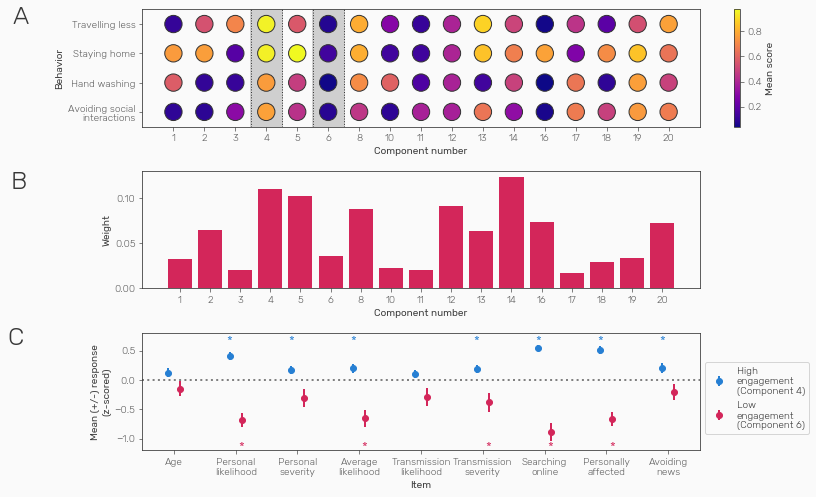

In [108]:
f, ax = plt.subplots(3, figsize=(12, 7))

xs = np.arange(means.shape[0])[:, np.newaxis].repeat(4, axis=1).T.flatten()
ys = np.arange(4)[:, np.newaxis].repeat(means.shape[0], axis=1).flatten()

# Highlight good and bad
ax[0].axvline(np.argmin(means.mean(axis=1)), color='#cfcfcf', linewidth=33, zorder=-1000)
ax[0].axvline(np.argmin(means.mean(axis=1)) + .5, color='#333333', linewidth=1, linestyle=':')
ax[0].axvline(np.argmin(means.mean(axis=1)) - .5, color='#333333', linewidth=1, linestyle=':')

ax[0].axvline(np.argmax(means.mean(axis=1)), color='#cfcfcf', linewidth=33, zorder=-1000)
ax[0].axvline(np.argmax(means.mean(axis=1)) + .5, color='#333333', linewidth=1, linestyle=':')
ax[0].axvline(np.argmax(means.mean(axis=1)) - .5, color='#333333', linewidth=1, linestyle=':')
im = ax[0].scatter(xs, ys, c=means.T.flatten(), cmap='plasma', s=300, edgecolor='#333333')
ax[0].set_ylim(-0.5, 3.5)
ax[0].set_yticks(range(4))
ax[0].set_yticklabels(['Avoiding social\ninteractions', 'Hand washing', 'Staying home', 'Travelling less'])
f.colorbar(im, ax=ax[0], label='Mean score')
ax[0].set_xticks(range(means.shape[0]))
ax[0].set_xticklabels(np.arange(20)[clf.weights_ > 0.01] + 1)
ax[0].set_xlim(-1, means.shape[0])
ax[0].set_xlabel('Component number')
ax[0].set_ylabel('Behavior')

ax[0].text(-5.2, 3, 'A', fontsize=25)

ax[1].bar(range(len(clf.weights_[clf.weights_ > 0.01])), clf.weights_[clf.weights_ > 0.01], color='#d3265a')
ax[1].set_xlabel('Component number')
ax[1].set_ylabel('Weight')
ax[1].set_xticks(range(means.shape[0]))
ax[1].set_xticklabels(np.arange(20)[clf.weights_ > 0.01] + 1)
cb = f.colorbar(im, ax=ax[1], shrink=0.001)
cb.set_ticks([])

ax[1].text(-5.6, 0.11, 'B', fontsize=25)

q_labels = ['Age', 'Personal\nlikelihood', 'Personal\nseverity', 'Average\nlikelihood', 
            'Transmission\nlikelihood', 'Transmission\nseverity', 'Searching\nonline', 'Personally\naffected', 'Avoiding\nnews']

ax[2].axhline(0, linestyle=':', color='gray', linewidth=2)
ax[2].errorbar(y=m[:, 0], x=np.arange(m.shape[0]) - 0.1, yerr=se[:, 0], fmt='o', linewidth=2, color='#267fd3', label='High\nengagement\n(Component 4)')
ax[2].errorbar(y=m[:, 1], x=np.arange(m.shape[0]) + 0.1, yerr=se[:, 1], fmt='o', linewidth=2, color='#d3265a', label='Low\nengagement\n(Component 6)')
ax[2].set_xticks(range(len(continuous_qs)))
ax[2].set_xticklabels(q_labels)

for i in range(sig.shape[0]):
    if sig[i, 0]:
        ax[2].text(i - 0.15, 0.6, '*', size=13, color='#267fd3')
    if sig[i, 1]:
        ax[2].text(i + 0.04, -1.2, '*', size=13, color='#d3265a')
        
ax[2].set_ylim(-1.2, 0.8)

ax[2].legend(bbox_to_anchor=(1, 0.8))
ax[2].set_xlabel("Item")
ax[2].set_ylabel('Mean (+/-) response\n(z-scored)')
cb = f.colorbar(im, ax=ax[2], shrink=0.001)
cb.set_ticks([])

ax[2].text(-2.7, 0.6, 'C', fontsize=25)

plt.tight_layout()

plt.savefig('../figures/GMM_components.png')
plt.savefig('../figures/GMM_components.svg')